In [10]:
import numpy as np 
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import sqlite3
import sqlalchemy
from tqdm import tqdm


PathStochastic="./StochasticFiles/"
SqliteNamesStochastic={"Hurricane": "NC_EnergySystem2023.sqlite"}


###############################################################################################################
#### Outputs from the sqlite files we are interested


# OutputSqlTables={"Output_CapacityByPeriodAndTech":"",
#                  "Output_Costs":"",
#                  "Output_Curtailment":"",
#                  "Output_Duals":"",
#                  "Output_Emissions":"",
#                  "Output_Objective":"",
#                  "Output_VFlow_In":"",
#                  "Output_VFlow_Out":"",
#                  "Output_V_Capacity":""}

OutputSqlTables={"Output_CapacityByPeriodAndTech":[],
                 "Output_Emissions":[],
                 "Output_VFlow_Out":[]}

# Read sqlite files stochastic

In [11]:


for simulation in tqdm(list(SqliteNamesStochastic.keys())):
    SqliteName=SqliteNamesStochastic[simulation]

    SqlitePath=PathStochastic+SqliteName
    
    for table_name in list(OutputSqlTables.keys()):
        engine = sqlalchemy.create_engine("sqlite:///%s" % SqlitePath, execution_options={"sqlite_raw_colnames": True})

        df = pd.read_sql_table(table_name, engine)

        OutputSqlTables[table_name].append(df)

100%|██████████| 1/1 [00:08<00:00,  8.52s/it]


# Define group of technologies we may want to plot

In [12]:
TechAtGroups={"Biomass":["AB_ST_EXISTING","BLQ_ST_EXISTING","OBG_IC_EXISTING","WDS_ST_EXISTING",
                        "WH_ST_EXISTING","LFG_GT_EXISTING","LFG_IC_EXISTING","BIOMASS_NEW","BIOMASS_CC90_NEW"],

                "Biomass_CCS":["BIOMASS_CC90_NEW"],

                # "Coal":["BIT_ST_EXISTING","COAL_NEW","COAL_95CC_NEW","COAL_99CC_NEW"],

                # "Coal_CCS":["COAL_95CC_NEW","COAL_99CC_NEW"],

                "NaturalGas":["NG_CC_EXISTING","NG_GT_EXISTING","NG_ST_EXISTING",
                            "NG_F-FRAME_CT_NEW","NG_F-FRAME_CC_NEW","NG_H-FRAME_CC_NEW",
                            "NG_F-FRAME_CC_95CC_NEW","NG_H-FRAME_CC_95CC_NEW","NG_F-FRAME_CC_97CC_NEW",
                            "NG_H-FRAME_CC_97CC_NEW"],

                "NaturalGas_CCS":["NG_F-FRAME_CC_95CC_NEW","NG_H-FRAME_CC_95CC_NEW","NG_F-FRAME_CC_97CC_NEW",
                            "NG_H-FRAME_CC_97CC_NEW"],

                "Nuclear":["NUCLEAR-AP1000_NEW","NUCLEAR-SMR_NEW","NUC_ST_EXISTING"],

                # "Petrol":["DFO_CC_EXISTING","DFO_GT_EXISTING","DFO_IC_EXISTING"],

                "Hydro":["WAT_HY_NEW","WAT_HY_EXISTING"],

                "Solar":["PV-COMMERCIAL_NEW","PV-RESIDENTIAL_NEW","PV-UTILITY_NEW","SUN_PV_EXISTING"],

                "Wind_ON/OFF":["WIND-LAND-C8_NEW","WIND-OFFSHORE-C6_NEW","WND_WT_EXISTING"],

                "Wind_ON":["WIND-LAND-C8_NEW","WND_WT_EXISTING"],

                "Wind_OFF":["WIND-OFFSHORE-C6_NEW"],

                # "CO2 Stored":["CO2_STORAGE"],

                "EnergyStorage":["BATT_2H_NEW","BATT_4H_NEW","BATT_6H_NEW",
                                "BATT_8H_NEW","MWH_BA1H_EXISTING","MWH_BA2H_EXISTING",
                                "WAT_PS_EXISTING","WAT_PS_NEW"],

                "Coal/Petrol":["DFO_CC_EXISTING","DFO_GT_EXISTING","DFO_IC_EXISTING","BIT_ST_EXISTING","COAL_NEW","COAL_95CC_NEW","COAL_99CC_NEW"],

                #"Ocean Current":["OCEAN_CURRENT_NEW"]
                }

# Determine activity for each group

In [13]:
def SummarizeActivity(TechAtGroups=TechAtGroups,OutputSqlTables=OutputSqlTables):
    
    df_SummaryFlow=pd.DataFrame(columns=["simulation","scenario","period","period name","group","Activity"])
    
    for i in tqdm(range(len(list(SqliteNamesStochastic.keys())))):
        simulation=list(SqliteNamesStochastic.keys())[i]
        
        Output_VFlow_Out=OutputSqlTables["Output_VFlow_Out"][i]
        scenarios=Output_VFlow_Out["scenario"].unique()

        periods=Output_VFlow_Out["t_periods"].unique()
        periods.sort()
        periods=list(periods)+[2*periods[-1]-periods[-2]]

        PeriodName=[str(periods[i])+"-"+str(periods[i+1]) for i in range(len(periods)-1)]
        periods=periods[:-1]

        

        Groups=list(TechAtGroups.keys())

        for Group in Groups:
            techs=TechAtGroups[Group]

            #Filter for Tech in the group
            df=Output_VFlow_Out[Output_VFlow_Out["tech"].isin(techs)]
            df=df.groupby(["t_periods","scenario"])[["vflow_out"]].sum().reset_index()

            for scenario in scenarios:
                for period in periods:
                    df1=df[(df["scenario"]==scenario) & (df["t_periods"]==period)]

                    df_SummaryFlow_tmp=pd.DataFrame({"simulation":simulation,"scenario":scenario,"period":period,"group":Group,"Activity":df1["vflow_out"],
                                                    "period name":PeriodName[periods.index(period)]})

                    df_SummaryFlow=pd.concat([df_SummaryFlow,df_SummaryFlow_tmp],ignore_index=True)

    return df_SummaryFlow

df_SummaryFlow=SummarizeActivity()

100%|██████████| 1/1 [00:03<00:00,  3.73s/it]


# Determine the emissions for each group

In [14]:
def SummarizeEmissions(TechAtGroups=TechAtGroups,OutputSqlTables=OutputSqlTables, emission_name="co2_at"):

    df_SummaryEmissions=pd.DataFrame(columns=["simulation","scenario","period","period name","group","Emissions"])

    for i in tqdm(range(len(list(SqliteNamesStochastic.keys())))):
        simulation=list(SqliteNamesStochastic.keys())[i]
        
        Output_Emissions=OutputSqlTables["Output_Emissions"][i]
        scenarios=Output_Emissions["scenario"].unique()

        periods=Output_Emissions["t_periods"].unique()
        periods.sort()
        periods=list(periods)+[2*periods[-1]-periods[-2]]

        PeriodName=[str(periods[i])+"-"+str(periods[i+1]) for i in range(len(periods)-1)]
        periods=periods[:-1]

        Groups=list(TechAtGroups.keys())

        for Group in Groups:
            techs=TechAtGroups[Group]

            #Filter for Tech in the group
            df=Output_Emissions[Output_Emissions["tech"].isin(techs) * (Output_Emissions["emissions_comm"]==emission_name)]
            df=df.groupby(["t_periods","scenario"])[["emissions"]].sum().reset_index()

            for scenario in scenarios:
                for period in periods:
                    df1=df[(df["scenario"]==scenario) & (df["t_periods"]==period)]

                    df_SummaryEmissions_tmp=pd.DataFrame({"simulation":simulation,"scenario":scenario,"period":period,"group":Group,"Emissions":df1["emissions"],
                                                    "period name":PeriodName[periods.index(period)]})

                    df_SummaryEmissions=pd.concat([df_SummaryEmissions,df_SummaryEmissions_tmp],ignore_index=True)

    return df_SummaryEmissions

df_SummaryEmissions=SummarizeEmissions()

100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


# Determine the capacity for each group

In [15]:
def SummarizeCapacity(TechAtGroups=TechAtGroups,OutputSqlTables=OutputSqlTables):
    df_SummaryCapacity=pd.DataFrame(columns=["simulation","scenario","period","period name","group","Capacity"])

    for i in tqdm(range(len(list(SqliteNamesStochastic.keys())))):
        simulation=list(SqliteNamesStochastic.keys())[i]
        
        Output_CapacityByPeriodAndTech=OutputSqlTables["Output_CapacityByPeriodAndTech"][i]
        scenarios=Output_CapacityByPeriodAndTech["scenario"].unique()

        periods=Output_CapacityByPeriodAndTech["t_periods"].unique()
        periods.sort()
        periods=list(periods)+[2*periods[-1]-periods[-2]]

        PeriodName=[str(periods[i])+"-"+str(periods[i+1]) for i in range(len(periods)-1)]
        periods=periods[:-1]

        Groups=list(TechAtGroups.keys())

        for Group in Groups:
            techs=TechAtGroups[Group]

            #Filter for Tech in the group
            df=Output_CapacityByPeriodAndTech[Output_CapacityByPeriodAndTech["tech"].isin(techs)]
            df=df.groupby(["t_periods","scenario"])[["capacity"]].sum().reset_index()

            for scenario in scenarios:
                for period in periods:
                    df1=df[(df["scenario"]==scenario) & (df["t_periods"]==period)]

                    df_SummaryCapacity_tmp=pd.DataFrame({"simulation":simulation,"scenario":scenario,"period":period,"group":Group,"Capacity":df1["capacity"],
                                                    "period name":PeriodName[periods.index(period)]})

                    df_SummaryCapacity=pd.concat([df_SummaryCapacity,df_SummaryCapacity_tmp],ignore_index=True)

    return df_SummaryCapacity

df_SummaryCapacity=SummarizeCapacity()

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


# Plot the results per period

In [16]:
X_label="Year"
Y_tabel={"Activity":"TWh/yr","Emissions":"Mt CO2","Capacity":"GW"}
Data={"Activity":df_SummaryFlow,"Emissions":df_SummaryEmissions,"Capacity":df_SummaryCapacity}

#### - modify the following parameters to plot different groups
#Place of each group in the plot
PlotGroups=[]
PlotGroups.append(["Coal/Petrol","NaturalGas", "NaturalGas_CCS"])#Line 1
PlotGroups.append(["Wind_ON/OFF","Biomass","Biomass_CCS"])#Line 2
PlotGroups.append(["Solar","Nuclear", "Hydro"])#Line 3

Iten="Activity" # "Activity" or "Emissions" or "Capacity"

In [17]:
def Plot(Iten, PlotGroups, Data=Data):
    NumXplots=len(PlotGroups)
    NumYplots=len(PlotGroups[0])
    fig, axs = plt.subplots(NumXplots, NumYplots,figsize=(8, 8))

    Cases=Data[Iten]["simulation"].unique()
    Scenarios=Data[Iten]["scenario"].unique()

    Colors=list(mcolors.BASE_COLORS.keys())
    x=Data[Iten]["period name"].unique()

    YMax=0
    YMin=10*6

    #Scale from kt to MT
    if Iten=="Emissions":
        Scale=1e-3
    else:
        Scale=1

    for s in range(len(Scenarios)):
        scenario=Scenarios[s]
        for c in range(len(Cases)):
            Case=Cases[c]
            for i in range(NumXplots):
                for j in range(NumYplots):
                    group=PlotGroups[i][j]
                    y=np.zeros(len(x))

                    y_tmp=Data[Iten][(Data[Iten]["scenario"]==scenario) & (Data[Iten]["group"]==group)]
                    y_t=y_tmp["period name"]
                    y[[np.where(x==y_t.values[i])[0][0] for i in range(len(y_t.values))]]=y_tmp[Iten].values

                    axs[i, j].set_title(group)

                    axs[i, j].plot(x, y*Scale, Colors[c]+"-",alpha=0.5,label=Case)
                    axs[i, j].set_xticklabels(x, rotation=90)
                    YMin=min(YMin,axs[i, j].get_ylim()[0])
                    YMax=max(YMax,axs[i, j].get_ylim()[1])

        if s==0:
            lines_labels = [axs[0, 0].get_legend_handles_labels()]
            lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

    for i in range(NumXplots):
        for j in range(NumYplots):
            axs[i,j].set_ylim(YMin, YMax)

    plt.yticks(rotation = 95)
    plt.tight_layout() # Or equivalently,  "plt.tight_layout()"

    for ax in axs.flat:
        ax.label_outer()

    fig.supxlabel("Year")
    fig.supylabel(Iten+" ("+Y_tabel[Iten]+")")
    fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

    # lines_labels = [axs[0, 0].get_legend_handles_labels()]
    # lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

    fig.legend(lines, labels=labels,loc="lower center",ncol = 5, bbox_to_anchor=(0.5, -0.05),frameon=False)

    plt.savefig("Summary_Stochastic"+Iten+".png",dpi=600,bbox_inches='tight')

    return plt.show()


C:\Users\Remote\AppData\Local\Temp\ipykernel_27120\949417619.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i, j].set_xticklabels(x, rotation=90)
C:\Users\Remote\AppData\Local\Temp\ipykernel_27120\949417619.py:62: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend(lines, labels=labels,loc="lower center",ncol = 5, bbox_to_anchor=(0.5, -0.05),frameon=False)


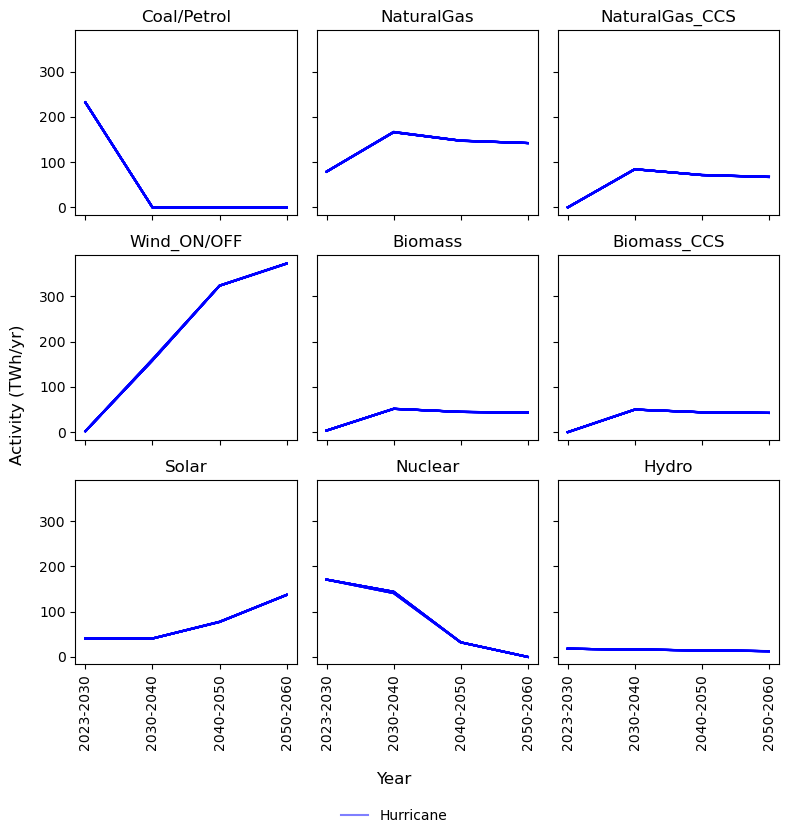

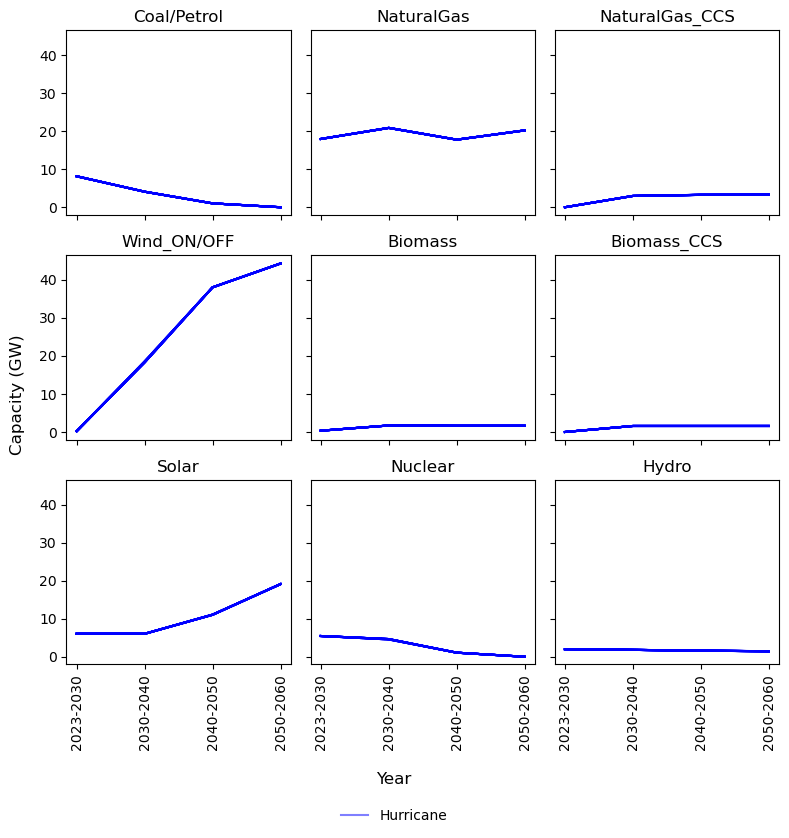

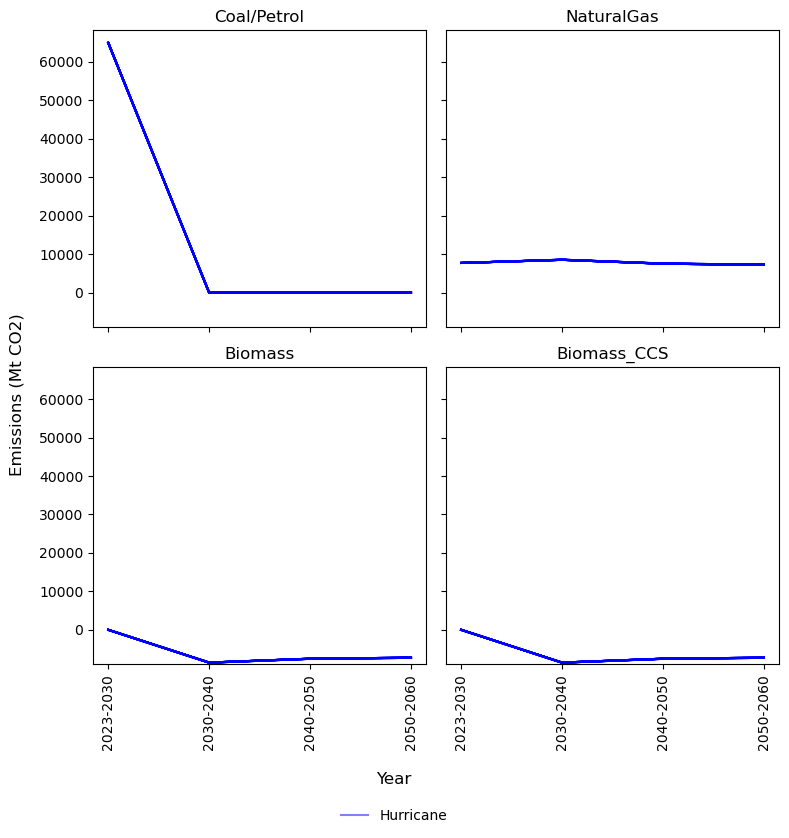

In [18]:
Iten="Activity" # "Activity" or "Emissions" or "Capacity"
PlotGroups=[]
PlotGroups.append(["Coal/Petrol","NaturalGas", "NaturalGas_CCS"])#Line 1
PlotGroups.append(["Wind_ON/OFF","Biomass","Biomass_CCS"])#Line 2
PlotGroups.append(["Solar","Nuclear", "Hydro"])#Line 3
Plot(Iten,PlotGroups)

################################
Iten="Capacity" # "Activity" or "Emissions" or "Capacity"
PlotGroups=[]
PlotGroups.append(["Coal/Petrol","NaturalGas", "NaturalGas_CCS"])#Line 1
PlotGroups.append(["Wind_ON/OFF","Biomass","Biomass_CCS"])#Line 2
PlotGroups.append(["Solar","Nuclear", "Hydro"])#Line 3
Plot(Iten,PlotGroups)

################################
Iten="Emissions" # "Activity" or "Emissions" or "Capacity"
PlotGroups=[]
PlotGroups.append(["Coal/Petrol","NaturalGas"])#Line 1
PlotGroups.append(["Biomass","Biomass_CCS"])#Line 2

Plot(Iten,PlotGroups)

# Plot the results per hour